# Cell Counting

Using https://www.researchgate.net/publication/374381260_Automated_Cell_Counting_using_Image_Processing as reference
<hr>
<img src = "process.png">
<hr>

## Aux Functions and Preparations:

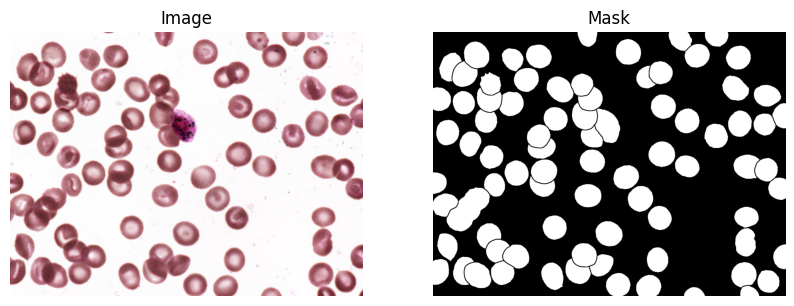

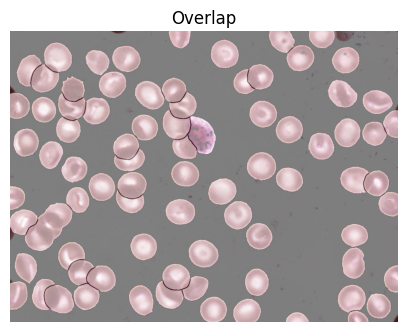

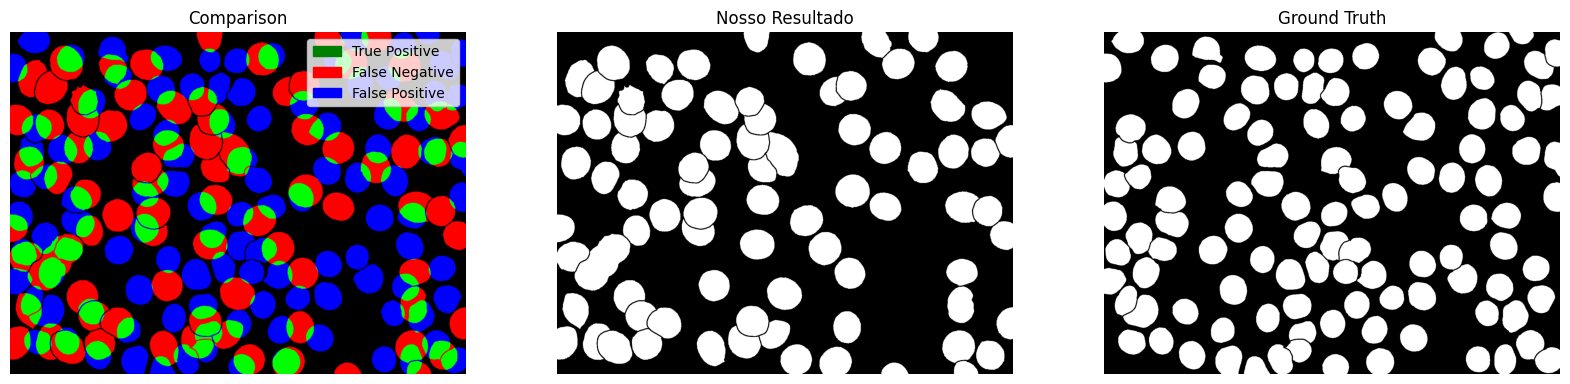

In [3]:

# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
import os

# Variables
img_path = os.path.join("BCCD_Dataset", "original") # Doing to prevent any path issues in different OS
mask_path = os.path.join("BCCD_Dataset", "mask")

images = []
masks = []
for filename in os.listdir(img_path): # Images
    file_path = os.path.join(img_path, filename)
    images.append(cv2.imread(file_path))

for filename in os.listdir(mask_path): # Masks
    file_path = os.path.join(mask_path, filename)
    masks.append(cv2.imread(file_path))


# Functions
def load_images(n_of_images:int = 10, img_path:str = img_path, mask_path:str = mask_path):
    images = []
    masks = []
    
    for filename in os.listdir(img_path)[:n_of_images]:
        file_path = os.path.join(img_path, filename)
        img = cv2.imread(file_path)
        images.append(img)

    for filename in os.listdir(mask_path)[:n_of_images]:
        file_path = os.path.join(mask_path, filename)
        mask = cv2.imread(file_path)
        masks.append(mask)
        
    return images, masks

def show_img_and_mask(img, mask, title_1 = "Image", title_2 = "Mask"):	
    plt.figure(figsize=(10, 10))

    plt.subplot(1,2,1)
    plt.axis("off")
    plt.imshow(img)
    plt.title(title_1)

    plt.subplot(1,2,2)
    plt.axis("off")
    plt.imshow(mask)
    plt.title(title_2)

def compare_two_images(img1, img2, title_1 = "Image 1", title_2 = "Image 2"):
    plt.figure(figsize=(10, 10))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.imshow(img1)
    plt.title(title_1)

    plt.subplot(1,2,2)
    plt.axis("off")
    plt.imshow(img2)
    plt.title(title_2)

    plt.show()

def show_img_and_mask_overlap(img, mask, title = "Overlap"):
    plt.figure(figsize=(5, 5))

    plt.axis("off")
    plt.imshow(img)
    plt.imshow(mask, alpha=0.5)
    plt.title(title)

def mask_comparison(mask_1, mask_2):
    new_mask = np.zeros(mask_1.shape)

    # False Positive
    blue = (mask_1[:, :, 0] == 255) & (mask_2[:, :, 0] != 255)
    new_mask[blue, 0] = 255

    # True Positive
    green = (mask_1[:, :, 0] == 255) & (mask_2[:, :, 0] == 255)
    new_mask[green, 1] = 255

    # False Negative
    red = (mask_1[:, :, 0] != 255) & (mask_2[:, :, 0] == 255)
    new_mask[red, 2] = 255

    new_mask[:, : , 0] = blue
    new_mask[:,:, 1] = green
    new_mask[:,:, 2] = red

    green_patch = mpatches.Patch(color='green', label='True Positive')
    red_patch = mpatches.Patch(color='red', label='False Negative')
    blue_patch = mpatches.Patch(color='blue', label='False Positive')

    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.imshow(new_mask)
    plt.axis("off")
    plt.title("Comparison")
    plt.legend(handles=[green_patch, red_patch, blue_patch], loc='upper right')

    plt.subplot(1,3,2)
    plt.imshow(mask_1)
    plt.axis("off")
    plt.title("Nosso Resultado")

    plt.subplot(1,3,3)
    plt.imshow(mask_2)
    plt.axis("off")
    plt.title("Ground Truth")

    plt.show()

# Min area eh o tamanho minimo de uma celula. Usado para evitar ruido
def count_cells(binary_image, min_area = 100):
    # Converter para grayscale 
    if len(binary_image.shape) == 3:
        binary_image = cv2.cvtColor(binary_image, cv2.COLOR_BGR2GRAY)
    
    # Encontrar contornos
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Criar copia para desenhar contornos
    contour_img = cv2.cvtColor(binary_image.copy(), cv2.COLOR_GRAY2BGR)
    

    cell_count = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_area:
            cv2.drawContours(contour_img, [contour], -1, (0, 255, 0), 2)
            cell_count += 1
    
    return contour_img, cell_count

def count_connected_components(image):
    # Converter para grayscale se nao for grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Aplicar threshold
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    
    # Contar componentes conectados
    num_features, _ = cv2.connectedComponents(binary)
    return num_features - 1  # Subtrair 1 para excluir o background






show_img_and_mask(images[0], masks[0])
show_img_and_mask_overlap(images[0], masks[0])
mask_comparison(masks[0], masks[1])

## Image Acquisition:

Primeira e ultima imagem importadas:


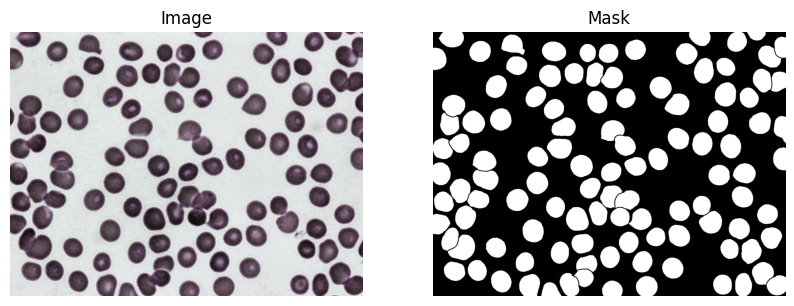

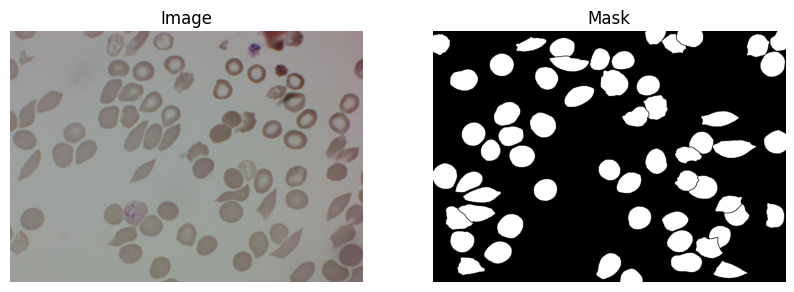

In [4]:
images, masks = load_images(10)
print(f'Primeira e ultima imagem importadas:')
show_img_and_mask(images[1], masks[1])
show_img_and_mask(images[-1], masks[-1])

## Image Segmentation:

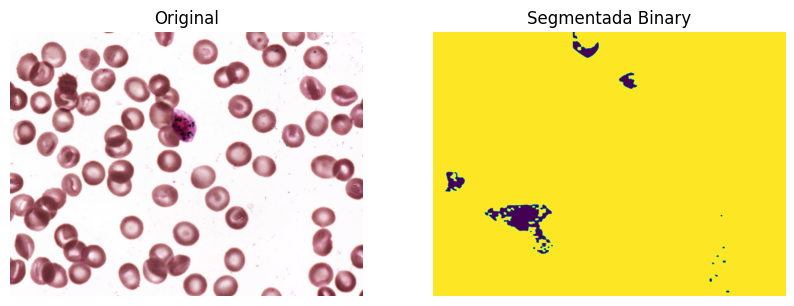

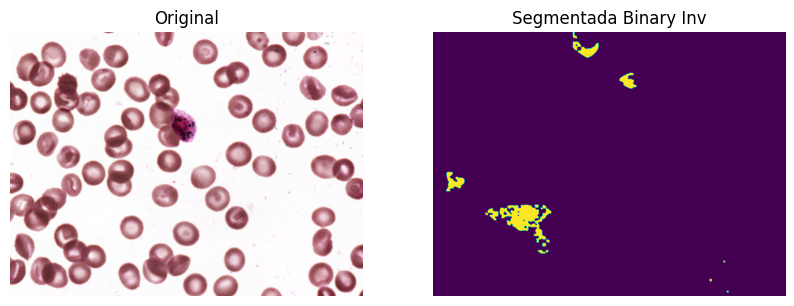

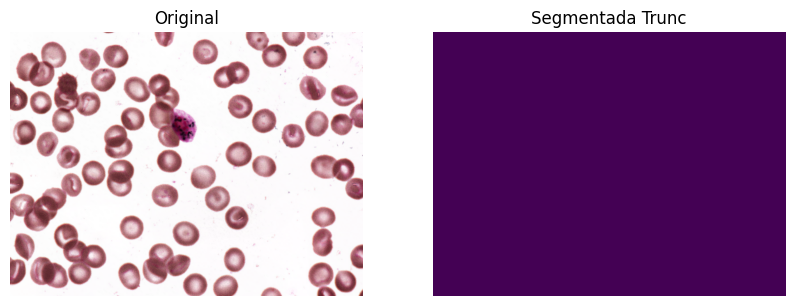

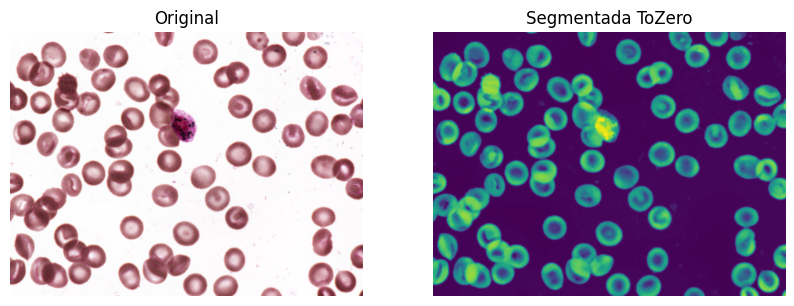

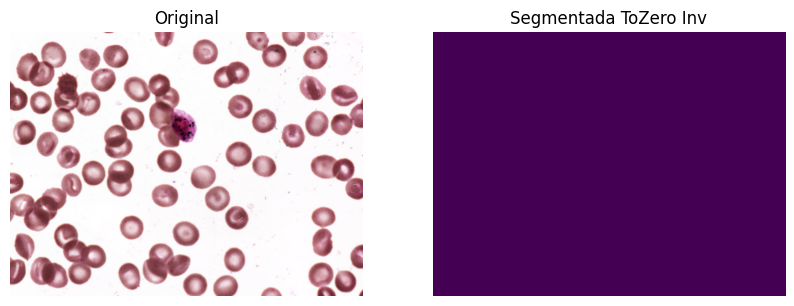

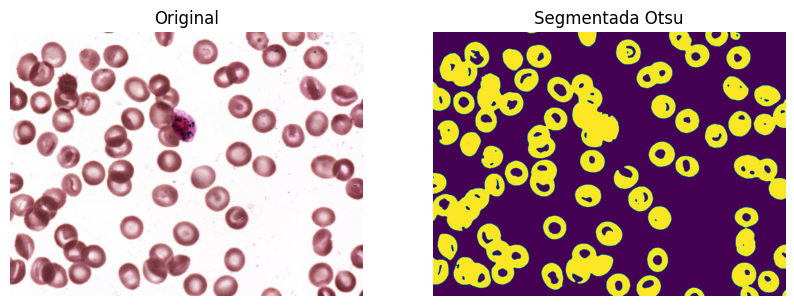

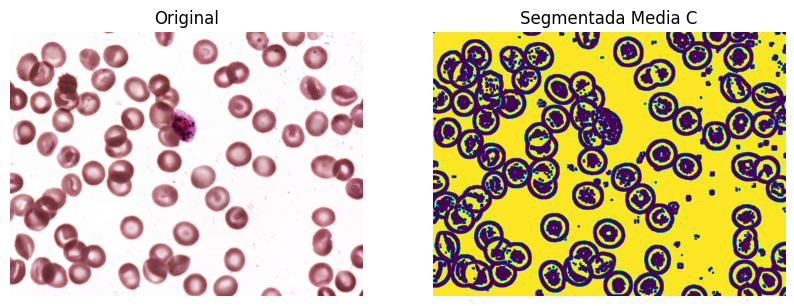

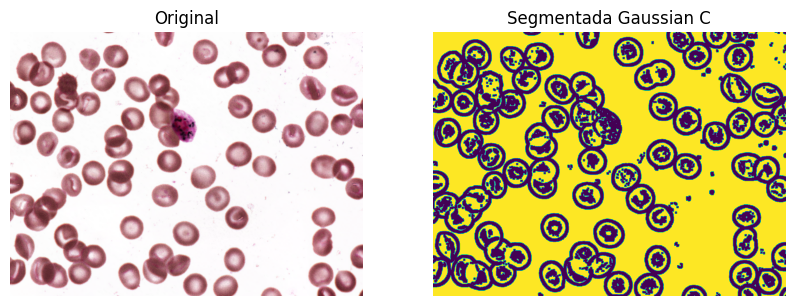

In [5]:
def segment_image_global(image, kernel_size = (3,3), method = cv2.THRESH_OTSU):
    kernel = np.ones(kernel_size, np.uint8)
    # Converter pra grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # As celulas do dataset sao preto no branco, entao temos que inverter a imagem, se nao as operacoes de erosao e dilatacao ficam "invertidas"
    gray = 255-gray
    
    # Gaussian blur de lei
    blurred = cv2.GaussianBlur(gray, (7,7), 0)

    # Filtro de mediana para suavizar o ruido
    blurred = cv2.medianBlur(blurred, 9)

    # Aplicando Threshold
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + method)
    
    # Operacao de abertura para separar celulas
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=3)

    # Erosao um pouco agressiva para sumir com a escala no canto inferior direito
    erosion = cv2.erode(opening, kernel, iterations=4)

    return opening

def segment_image_adaptative(image, kernel_size = (3,3), method = cv2.ADAPTIVE_THRESH_MEAN_C, block_size:int = 11, c:int = 2):
    kernel = np.ones(kernel_size, np.uint8)
    # Converter pra grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # As celulas do dataset sao preto no branco, entao temos que inverter a imagem, se nao as operacoes de erosao e dilatacao ficam "invertidas"
    gray = 255-gray
    
    # Gaussian blur de lei
    blurred = cv2.GaussianBlur(gray, (7,7), 0)

    # Filtro de mediana para suavizar o ruido
    blurred = cv2.medianBlur(blurred, 9)

    # Aplicando Threshold Adaptativo
    thresh = cv2.adaptiveThreshold(blurred, 255, method, cv2.THRESH_BINARY, block_size, c)
    
    # Operacao de abertura para separar celulas
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Erosao um pouco agressiva para sumir com a escala no canto inferior direito
    erosion = cv2.erode(opening, kernel, iterations=4)

    return erosion




#@TODO: Fazer uma segmentacao watershed, tinha tentado mas ela acabou sumindo com muita celula entao apaguei
compare_two_images(images[0], segment_image_global(images[0], method=cv2.THRESH_BINARY), "Original", "Segmentada Binary")
compare_two_images(images[0], segment_image_global(images[0], method=cv2.THRESH_BINARY_INV), "Original", "Segmentada Binary Inv")
compare_two_images(images[0], segment_image_global(images[0], method=cv2.THRESH_TRUNC), "Original", "Segmentada Trunc")
compare_two_images(images[0], segment_image_global(images[0], method=cv2.THRESH_TOZERO), "Original", "Segmentada ToZero")
compare_two_images(images[0], segment_image_global(images[0], method=cv2.THRESH_TOZERO_INV), "Original", "Segmentada ToZero Inv")
compare_two_images(images[0], segment_image_global(images[0]), "Original", "Segmentada Otsu")

compare_two_images(images[0], segment_image_adaptative(images[0]), "Original", "Segmentada Media C")
compare_two_images(images[0], segment_image_adaptative(images[0], method=cv2.ADAPTIVE_THRESH_GAUSSIAN_C), "Original", "Segmentada Gaussian C")


In [6]:
# Copiei do https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html
def watershed_markers(image, kernel_size=(3,3)):
    # Converter para grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Aplicar Otsu
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Aplicar abertura para remover ruido
    kernel = np.ones(kernel_size, np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Encontrar background
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    
    # Encontrar foreground
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.6 * dist_transform.max(), 255, 0)
    
    # Encontrar regiao desconhecida
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Criar marcadores
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown==255] = 0

    # Aplicar watershed
    markers = cv2.watershed(image, markers)

    # Binarizar
    markers_binary = np.zeros_like(markers, dtype=np.uint8)
    markers_binary[markers > 1] = 255 
    
    return markers_binary




## Object Identification:

# PARA ISSO É NECESSÁRIO USAR ML E IA SER MUITO TRAMPO

## Objects Counted:

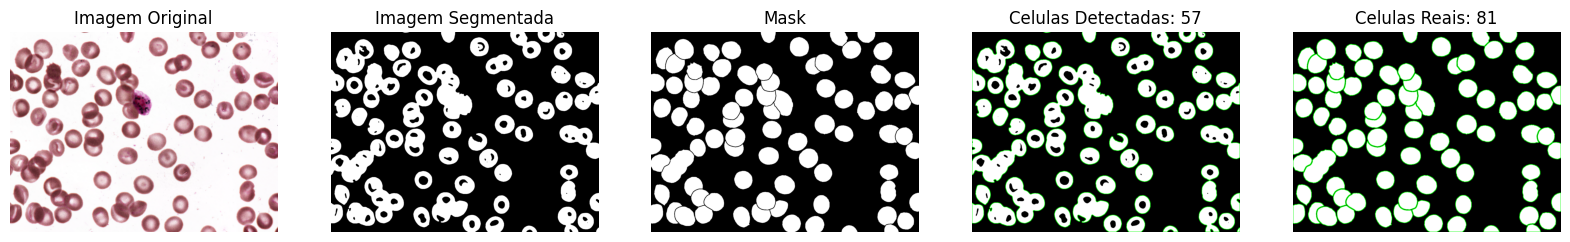

In [7]:
binary_image = segment_image_global(images[0])
contour_image, count = count_cells(binary_image)


plt.figure(figsize=(20, 5))
plt.subplot(151) 
plt.imshow(images[0])
plt.title('Imagem Original')
plt.axis('off')

plt.subplot(152)  
plt.imshow(binary_image, cmap='gray')
plt.title('Imagem Segmentada')
plt.axis('off')

plt.subplot(153) 
plt.imshow(masks[0])
plt.title('Mask')
plt.axis('off')

plt.subplot(154) 
plt.imshow(contour_image)
plt.title(f'Celulas Detectadas: {count}')
plt.axis('off')

plt.subplot(155)
mask_image, mask_count = count_cells(masks[0])   
plt.imshow(mask_image)
plt.title(f'Celulas Reais: {mask_count}')
plt.axis('off')

plt.show()


# COMPARISSON:

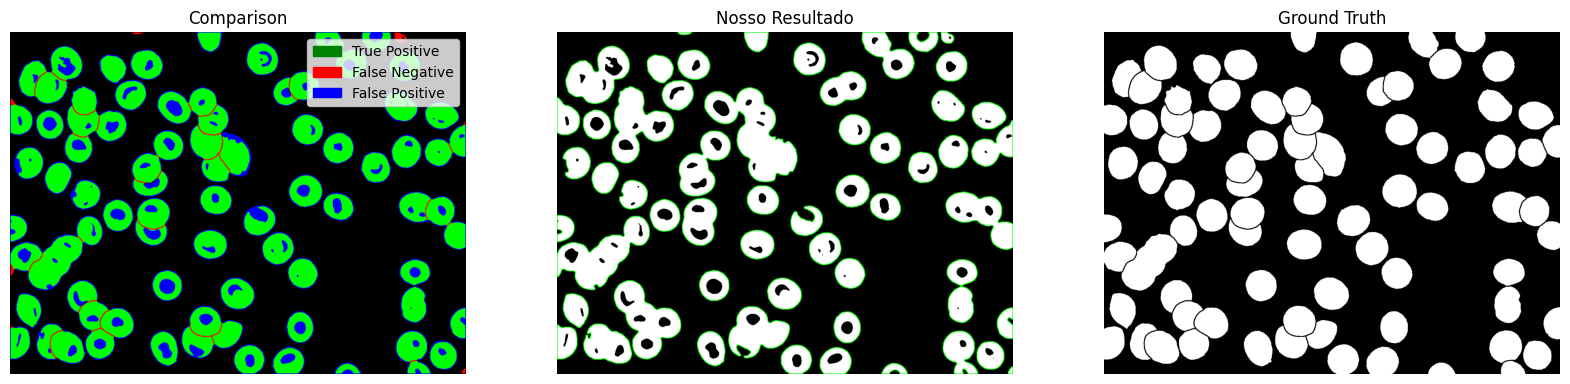

In [8]:
mask_comparison(contour_image, masks[0])

# WORKFLOW BCCD:

Precision: 0.98 | Recall: 0.87 | F1-Score: 0.92 | Accuracy: 0.95
nosso resultado = 57 | ground truth = 81


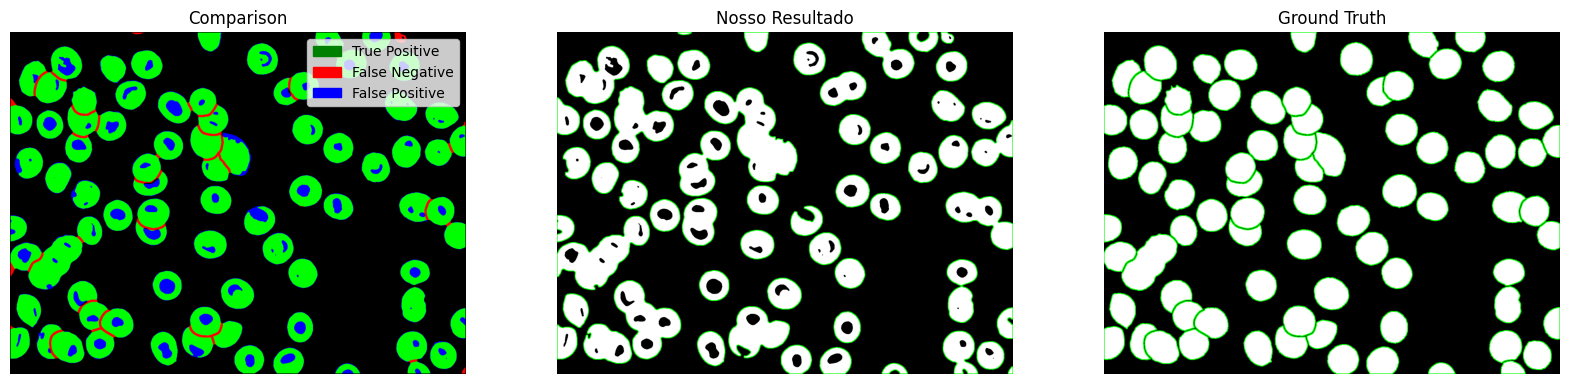

Precision: 0.99 | Recall: 0.96 | F1-Score: 0.97 | Accuracy: 0.98
nosso resultado = 99 | ground truth = 110


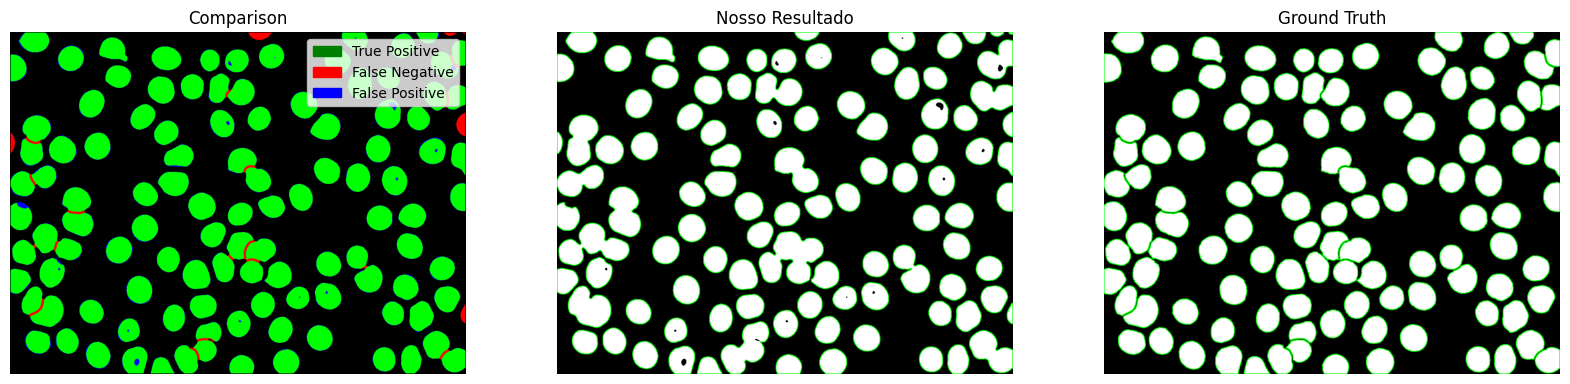

Precision: 0.95 | Recall: 0.93 | F1-Score: 0.94 | Accuracy: 0.96
nosso resultado = 57 | ground truth = 72


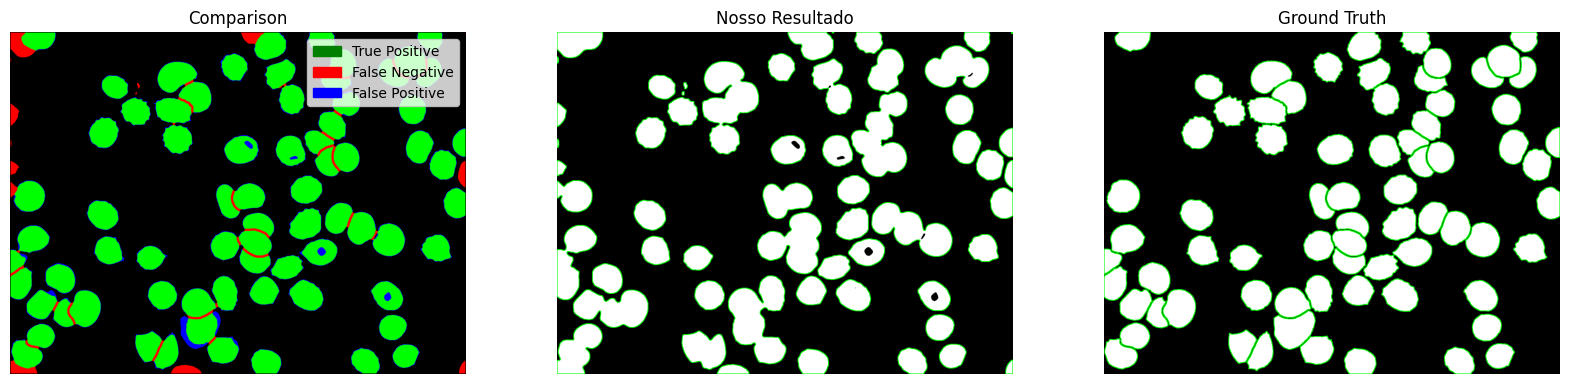

Precision: 0.97 | Recall: 0.91 | F1-Score: 0.94 | Accuracy: 0.95
nosso resultado = 106 | ground truth = 113


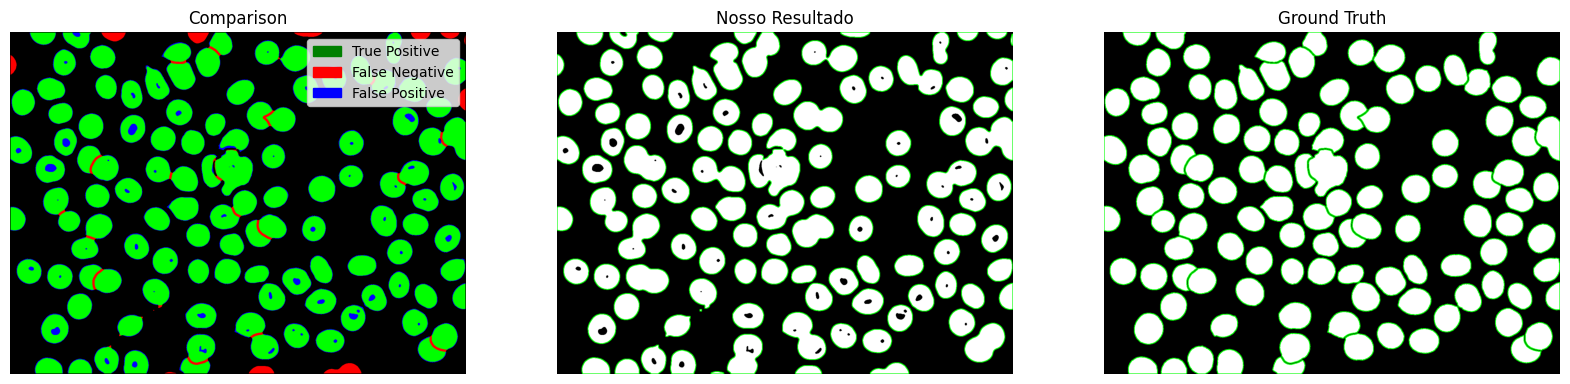

Precision: 0.89 | Recall: 0.96 | F1-Score: 0.92 | Accuracy: 0.95
nosso resultado = 30 | ground truth = 72


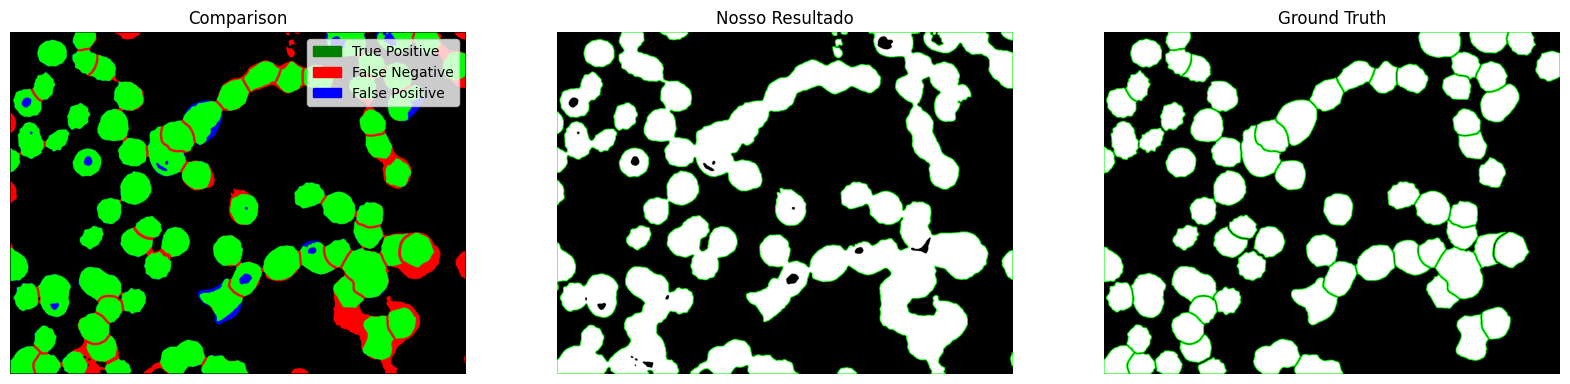

Precision: 0.91 | Recall: 0.92 | F1-Score: 0.92 | Accuracy: 0.94
nosso resultado = 44 | ground truth = 84


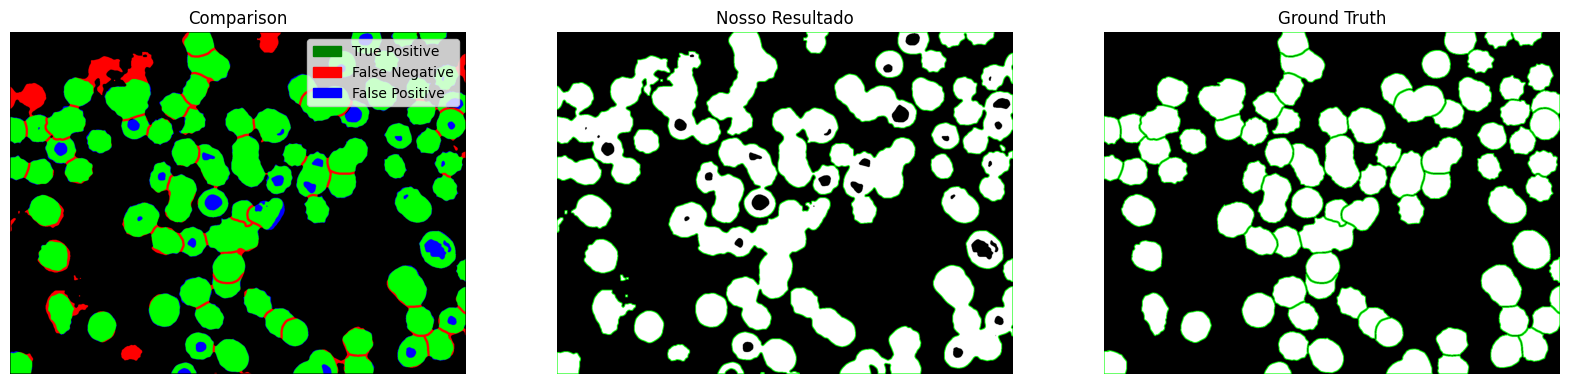

Precision: 0.95 | Recall: 0.92 | F1-Score: 0.94 | Accuracy: 0.97
nosso resultado = 65 | ground truth = 67


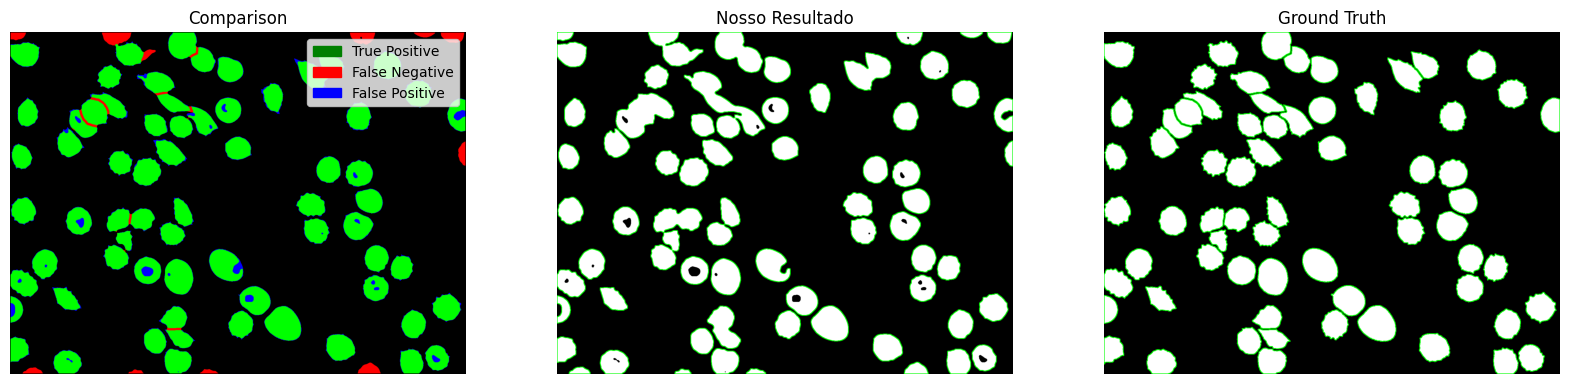

Precision: 0.96 | Recall: 0.85 | F1-Score: 0.90 | Accuracy: 0.96
nosso resultado = 42 | ground truth = 49


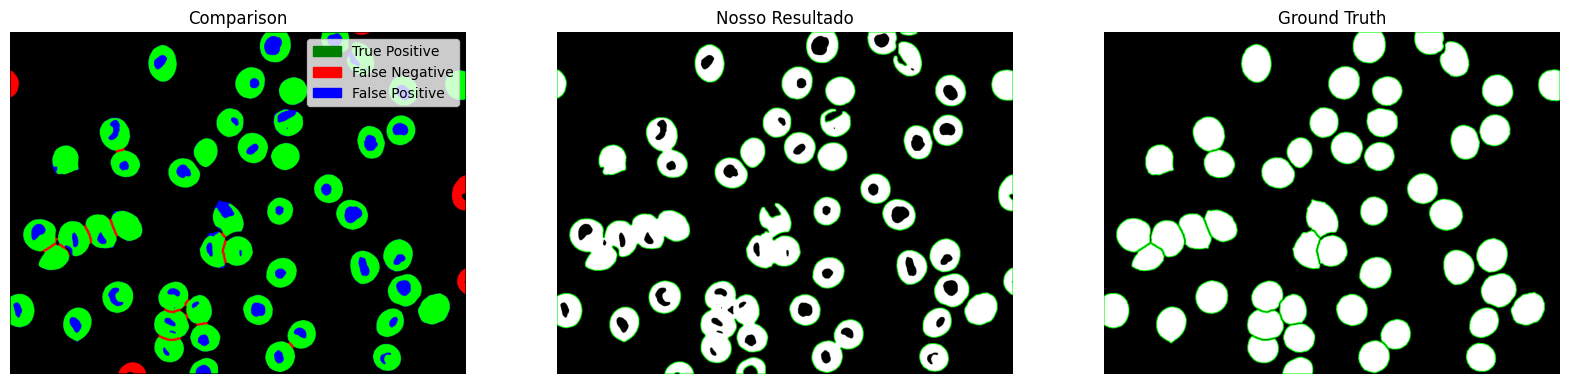

Precision: 0.97 | Recall: 0.93 | F1-Score: 0.95 | Accuracy: 0.96
nosso resultado = 57 | ground truth = 92


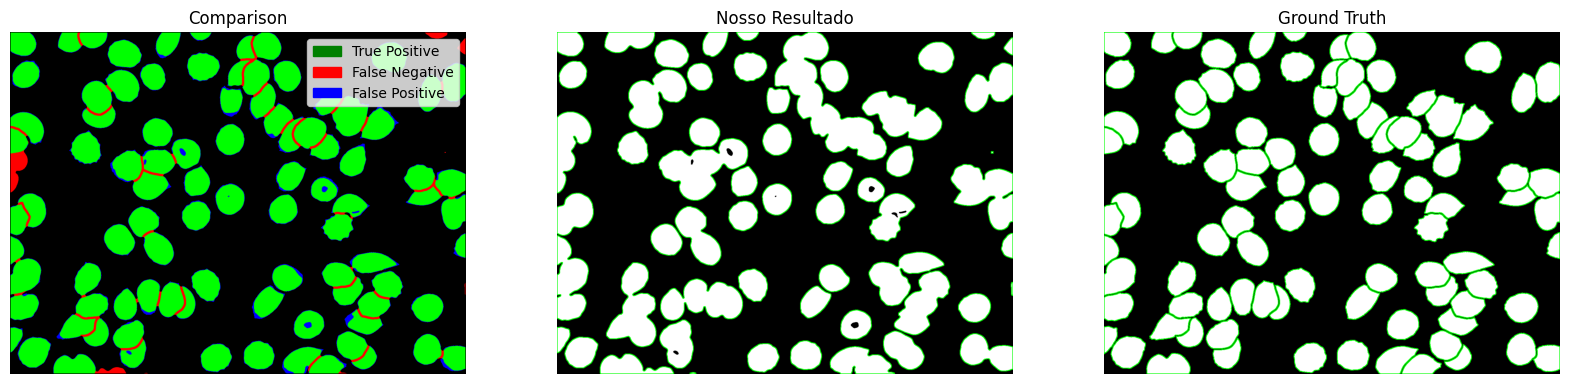

Media de Acertos na Contagem = 0.746750776273022


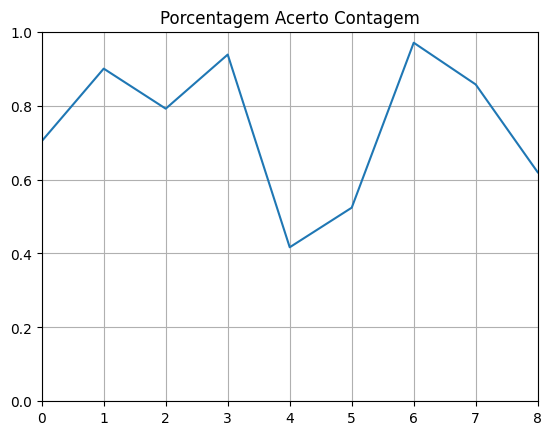

In [9]:
img_path_bccd = os.path.join("BCCD_Dataset", "original")
mask_path_bccd = os.path.join("BCCD_Dataset", "mask")

images_bccd, masks_bccd = load_images(9, img_path=img_path_bccd, mask_path=mask_path_bccd)
percentages = []
for image, mask in zip(images_bccd, masks_bccd):
    binary_image = segment_image_global(image)
    contour_image, count = count_cells(binary_image, min_area=1)
    countour_mask, mask_count = count_cells(mask, min_area=1)

    mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    tp = np.sum((binary_image == 255) & (mask_gray == 255))
    fp = np.sum((binary_image == 255) & (mask_gray == 0))
    fn = np.sum((binary_image == 0) & (mask_gray == 255))
    tn = np.sum((binary_image == 0) & (mask_gray == 0))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0
    
    print(f"Precision: {precision:.2f} | Recall: {recall:.2f} | F1-Score: {f1:.2f} | Accuracy: {accuracy:.2f}")
    
    abs_dif = abs(count-mask_count)

    percentages.append((mask_count-abs_dif)/mask_count)
    

    print(f'nosso resultado = {count} | ground truth = {mask_count}')
    mask_comparison(contour_image, countour_mask)
    
plt.title('Porcentagem Acerto Contagem')
plt.plot(percentages)
plt.axis([0, 8, 0.0, 1.0])
plt.grid()

percentages = np.array(percentages)
media_acertos_contagem = percentages.mean()
print(f'Media de Acertos na Contagem = {media_acertos_contagem}')

# WORKFLOW TNBC

Precision: 0.86 | Recall: 0.62 | F1-Score: 0.72 | Accuracy: 0.99
nosso resultado = 16 | ground truth = 20


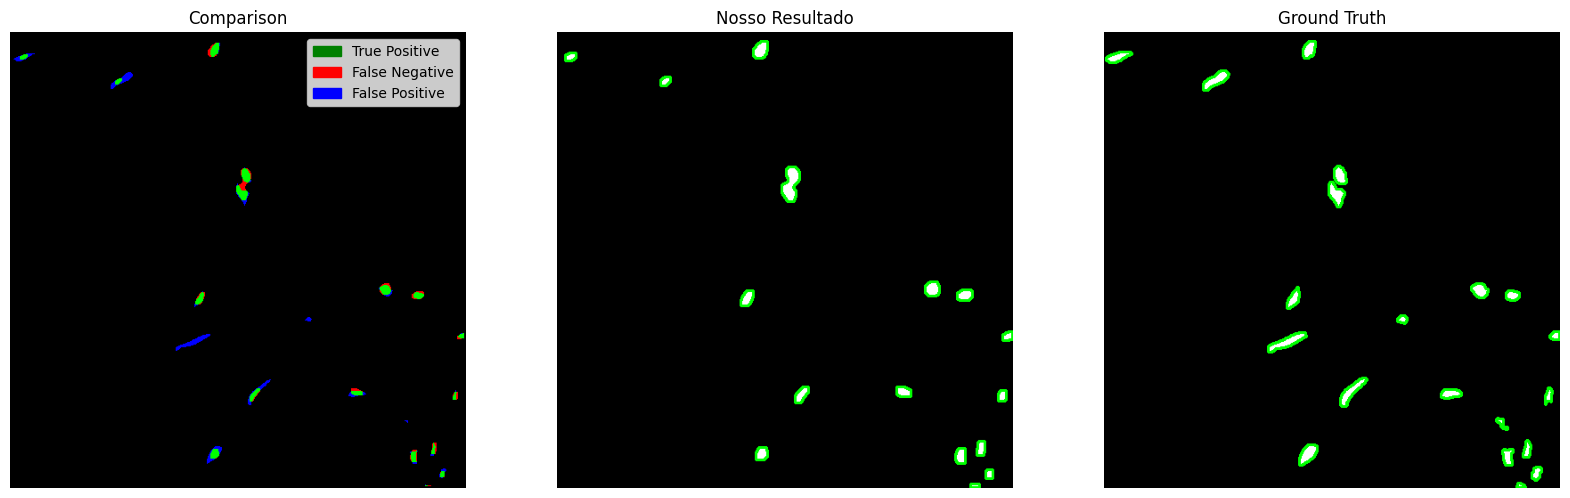

Precision: 0.75 | Recall: 0.77 | F1-Score: 0.76 | Accuracy: 0.96
nosso resultado = 65 | ground truth = 69


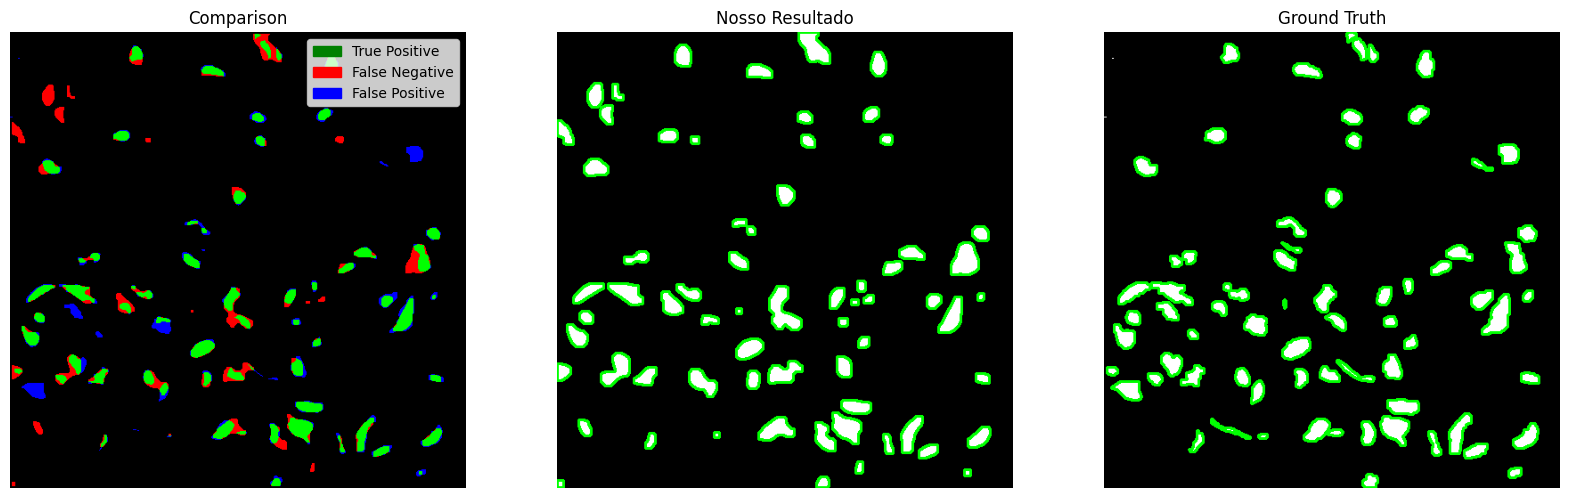

Precision: 0.67 | Recall: 0.89 | F1-Score: 0.77 | Accuracy: 0.92
nosso resultado = 114 | ground truth = 103


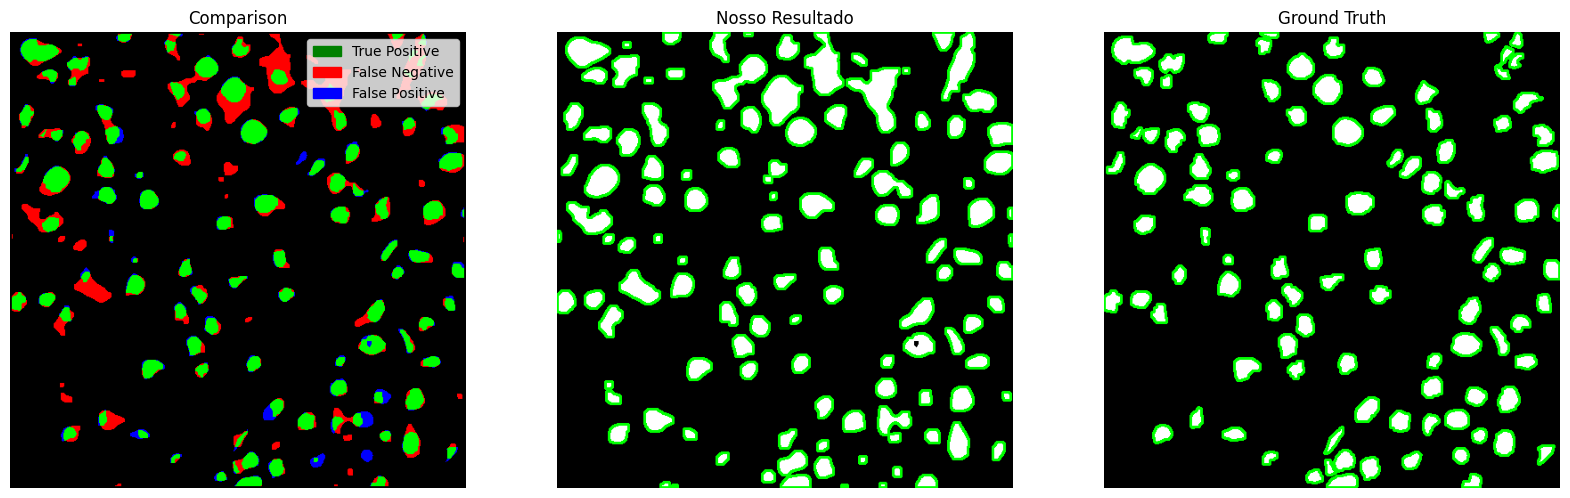

Precision: 0.75 | Recall: 0.80 | F1-Score: 0.77 | Accuracy: 0.97
nosso resultado = 58 | ground truth = 66


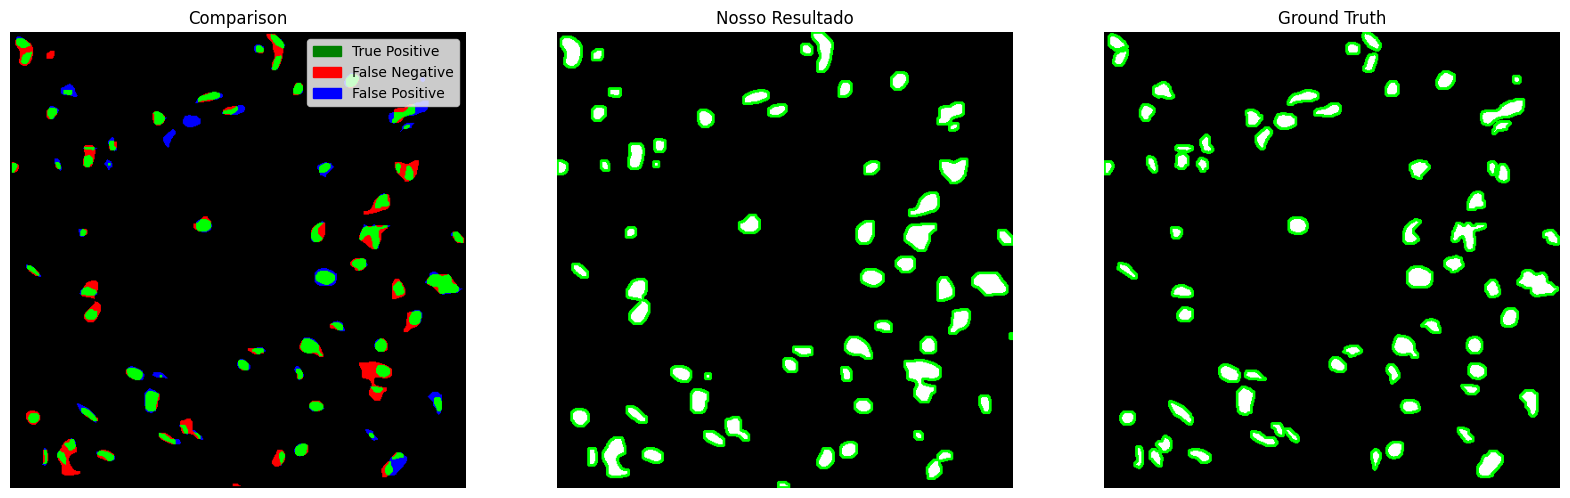

Precision: 0.58 | Recall: 0.85 | F1-Score: 0.69 | Accuracy: 0.98
nosso resultado = 33 | ground truth = 29


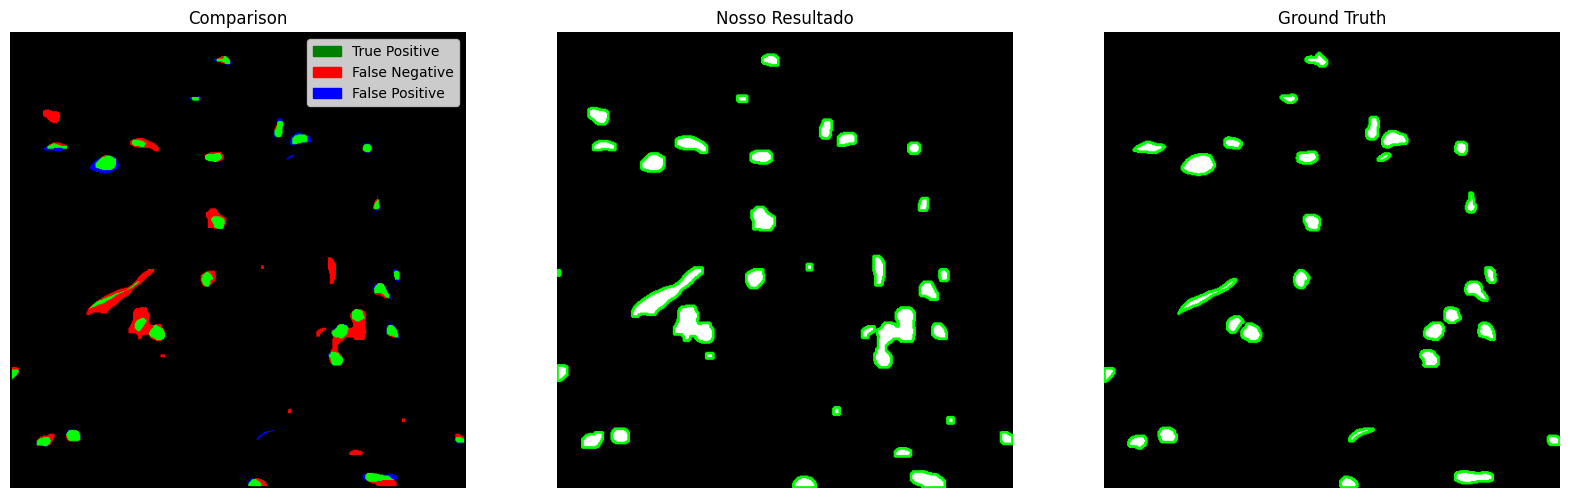

Media de Acertos na Contagem = 0.8752179426615024


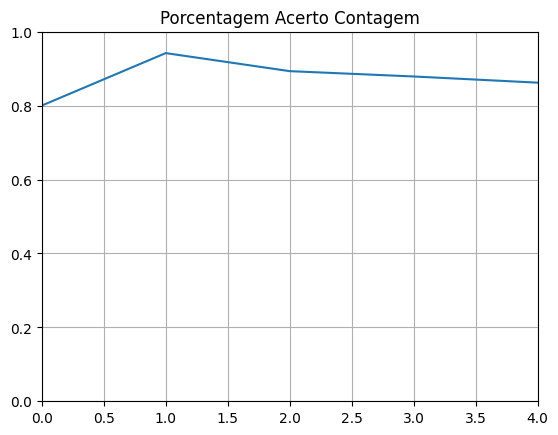

In [11]:

img_path_tnbc = os.path.join("TNBC_Dataset", "Slide_03")
mask_path_tnbc = os.path.join("TNBC_Dataset", "GT_03")

images_tnbc, masks_tnbc = load_images(5, img_path=img_path_tnbc, mask_path=mask_path_tnbc)
percentages = []
for image, mask in zip(images_tnbc, masks_tnbc):
    binary_image = segment_image_global(image)
    contour_image, count = count_cells(binary_image, min_area=1)
    countour_mask, mask_count = count_cells(mask, min_area=1)
    mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    tp = np.sum((binary_image == 255) & (mask_gray == 255))
    fp = np.sum((binary_image == 255) & (mask_gray == 0))
    fn = np.sum((binary_image == 0) & (mask_gray == 255))
    tn = np.sum((binary_image == 0) & (mask_gray == 0))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0
    
    print(f"Precision: {precision:.2f} | Recall: {recall:.2f} | F1-Score: {f1:.2f} | Accuracy: {accuracy:.2f}")

    abs_dif = abs(count-mask_count)
    percentages.append((mask_count-abs_dif)/mask_count)

    print(f'nosso resultado = {count} | ground truth = {mask_count}')
    mask_comparison(contour_image, countour_mask)
    
plt.title('Porcentagem Acerto Contagem')
plt.plot(percentages)
plt.axis([0, 4, 0.0, 1.0])
plt.grid()

percentages = np.array(percentages)
media_acertos_contagem = percentages.mean()
print(f'Media de Acertos na Contagem = {media_acertos_contagem}')